In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import pydotplus
from ipywidgets import *
from IPython.display import display
from IPython.display import Image
plt.rcParams["figure.figsize"] = (20, 15)
plt.rcParams["font.size"] = 14
plt.style.use("ggplot")
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
from scipy import stats
# from pygeocoder import Geocoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import LinearRegression,LogisticRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
std_scaler = StandardScaler()
rob_scaler = RobustScaler()
mm_scaler = MinMaxScaler()

In [2]:
austin = pd.read_pickle("../pickled_data/austin_all.pickled")
sanfran = pd.read_pickle("../pickled_data/sf_all_df.pickled")
LA = pd.read_pickle("../pickled_data/LA_new_df.pickled")
chicago = pd.read_pickle("../pickled_data/chicago_trips_df.pickled")
london = pd.read_pickle("../pickled_data/london_counts_df.pickled")
DC = pd.read_pickle("../pickled_data/DC_df.pickled")

In [3]:
austin.columns

Index(['bikeid', 'checkout_time', 'duration_minutes', 'end_station_name',
       'start_station_name', 'start_time', 'subscriber_type', 'trip_id',
       'Start_Day', 'Month', 'is_workday', 'start_date', 'Date', 'TempHighF',
       'TempAvgF', 'TempLowF', 'DewPointHighF', 'DewPointAvgF', 'DewPointLowF',
       'HumidityHighPercent', 'HumidityAvgPercent', 'HumidityLowPercent',
       'SeaLevelPressureHighInches', 'SeaLevelPressureAvgInches',
       'SeaLevelPressureLowInches', 'VisibilityHighMiles',
       'VisibilityAvgMiles', 'VisibilityLowMiles', 'WindHighMPH', 'WindAvgMPH',
       'WindGustMPH', 'PrecipitationSumInches', 'Events', 'TempAvgC',
       'DewPointAvgC', 'WindAvgKmH', 'dateasdatetime'],
      dtype='object')

# Pipeline:

In [4]:
scaler = StandardScaler()
class_model = LogisticRegression(solver='lbfgs', random_state=1)
model = LinearRegression()

In [5]:
pipe = Pipeline(steps=[('scaler', scaler),
                       ('model', model)])
pipe_class = Pipeline(steps=[('scaler', scaler),
                       ('model', class_model)])

# Austin
LINEAR

In [6]:
austin_per_day = austin.groupby("dateasdatetime").mean()
austin_per_day["count"] = austin.dateasdatetime.value_counts()
austin_per_day.dropna(inplace=True)
X = austin_per_day.copy()
y = X.pop('count')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
pipe.fit(X_train, y_train)
print(cross_val_score(pipe, X_train, y_train, cv=5).mean())
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.08109742615830821
0.16951690550163967
0.15147228291658688


In [7]:
austin_per_day.index.min(),austin_per_day.index.max()

(datetime.date(2013, 12, 21), datetime.date(2017, 7, 31))

In [8]:
pd.date_range(start = \
              austin_per_day.index.min(), end = austin_per_day.index.max() ).difference(austin_per_day.index)

DatetimeIndex(['2014-06-13', '2014-06-14', '2014-06-15', '2014-06-16',
               '2014-08-31', '2015-08-09', '2015-08-10', '2015-08-11',
               '2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04',
               '2016-04-05', '2016-04-06', '2016-04-07', '2016-04-08',
               '2016-04-09', '2016-04-10', '2016-04-11', '2016-04-12',
               '2016-04-13', '2016-04-14', '2016-04-15', '2016-04-16',
               '2016-04-17', '2016-04-18', '2016-04-19', '2016-04-20',
               '2016-04-21', '2016-04-22', '2016-04-23', '2016-04-24',
               '2016-04-25', '2016-04-26', '2016-04-27', '2016-04-28',
               '2016-04-29', '2016-04-30', '2016-12-01', '2016-12-02',
               '2016-12-03', '2016-12-04', '2016-12-05', '2016-12-06',
               '2016-12-07', '2016-12-08', '2016-12-09', '2016-12-10',
               '2016-12-11', '2016-12-12', '2016-12-13', '2016-12-14',
               '2016-12-15', '2016-12-16', '2016-12-17', '2016-12-18',
      

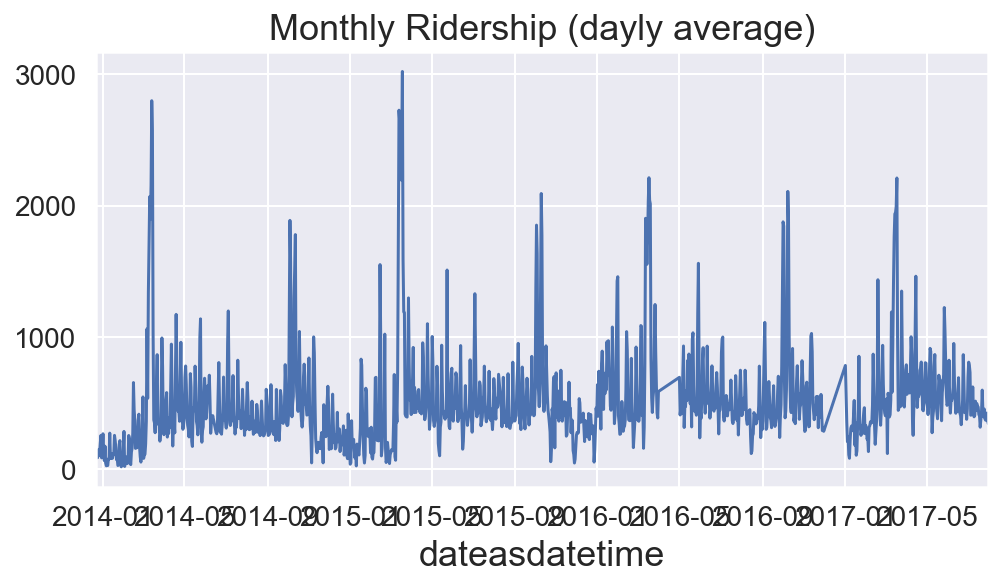

In [9]:
austin_per_day['count'].plot(
    figsize=(8, 4), title='Monthly Ridership (dayly average)', fontsize=14)
plt.show()

CLASSIFICATION

In [49]:
austin_per_day = austin.groupby("dateasdatetime").mean()
austin_per_day["count"] = austin.dateasdatetime.value_counts()
mean_count = austin_per_day['count'].mean()
list_bin = []
for val in austin_per_day['count']:
    if val > mean_count:
        list_bin.append(1)
    else:
        list_bin.append(0)
        
austin_per_day['count_class'] = list_bin
austin_per_day.dropna(inplace=True)
del austin_per_day['count']
X = austin_per_day.copy()
y = X.pop('count_class')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1)
pipe_class.fit(X_train, y_train)
# print(pipe.named_steps['model'].coef_)
print('Baseline:',austin_per_day.count_class.value_counts(normalize=True).max())
print('cross_val_score:', cross_val_score(pipe_class, X_train, y_train, cv=5).mean())
print('train_score:',pipe_class.score(X_train, y_train))
print('test_score:',pipe_class.score(X_test, y_test))

Baseline: 0.6448
cross_val_score: 0.7645489625317212
train_score: 0.7645714285714286
test_score: 0.7493333333333333


In [50]:
austin_per_day.head()

bikeid  duration_minutes       trip_id  is_workday  \
dateasdatetime                                                           
2013-12-21      364.640777         29.135922  9.900334e+09         0.0   
2013-12-22      465.743590         40.461538  9.900334e+09         0.0   
2013-12-23      403.437500         55.604167  9.900334e+09         1.0   
2013-12-24      414.188235         31.964706  9.900334e+09         1.0   
2013-12-25      387.386207         49.296552  9.900334e+09         0.0   

                TempHighF  TempAvgF  TempLowF  DewPointAvgF  \
dateasdatetime                                                
2013-12-21           74.0      60.0      45.0          49.0   
2013-12-22           56.0      48.0      39.0          36.0   
2013-12-23           58.0      45.0      32.0          27.0   
2013-12-24           61.0      46.0      31.0          28.0   
2013-12-25           58.0      50.0      41.0          40.0   

                HumidityAvgPercent  WindAvgMPH   TempAvgC  DewPointAvgC  \
dateasdatetime                                                            
2013-12-21                    75.0         4.0  15.555556      9.444444   
2013-12-22                    68.0         6.0   8.888889      2.222222   
2013-12-23                    52.0         3.0   7.222222     -2.777778   
2013-12-24                    56.0         4.0   7.777778     -2.222222   
2013-12-25                    71.0         2.0  10.000000      4.444444   

                WindAvgKmH  count_class  
dateasdatetime                           
2013-12-21           6.436            0  
2013-12-22           9.654            0  
2013-12-23           4.827            0  
2013-12-24           6.436            0  
2013-12-25           3.218            0

# San Fran
LINEAR

In [11]:
sf_per_day = sanfran.groupby([sanfran["start_date"].dt.date]).mean()
sf_per_day["count"] = sanfran.groupby([sanfran["start_date"].dt.date]).count()["mean_temperature_c"]
sf_per_day.dropna(inplace=True)
X = sf_per_day.copy()
y = X.pop('count')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
pipe.fit(X_train, y_train)
print(cross_val_score(pipe, X_train, y_train, cv=5).mean())
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))
# print(pipe.named_steps['model'].coef_)

0.848413493107693
0.8717284873080158
0.7878210684149505


In [12]:
sanfran.subscription_type.value_counts()

Subscriber    566745
Customer      103210
Name: subscription_type, dtype: int64

In [13]:
pd.date_range(start = \
              sf_per_day.index.min(), end = sf_per_day.index.max() ).difference(sf_per_day.index)

DatetimeIndex(['2014-06-02', '2014-07-02', '2014-08-31', '2014-09-03',
               '2014-10-22', '2015-03-25', '2015-05-04', '2015-06-16',
               '2015-07-01', '2015-08-14', '2015-08-19'],
              dtype='datetime64[ns]', freq=None)

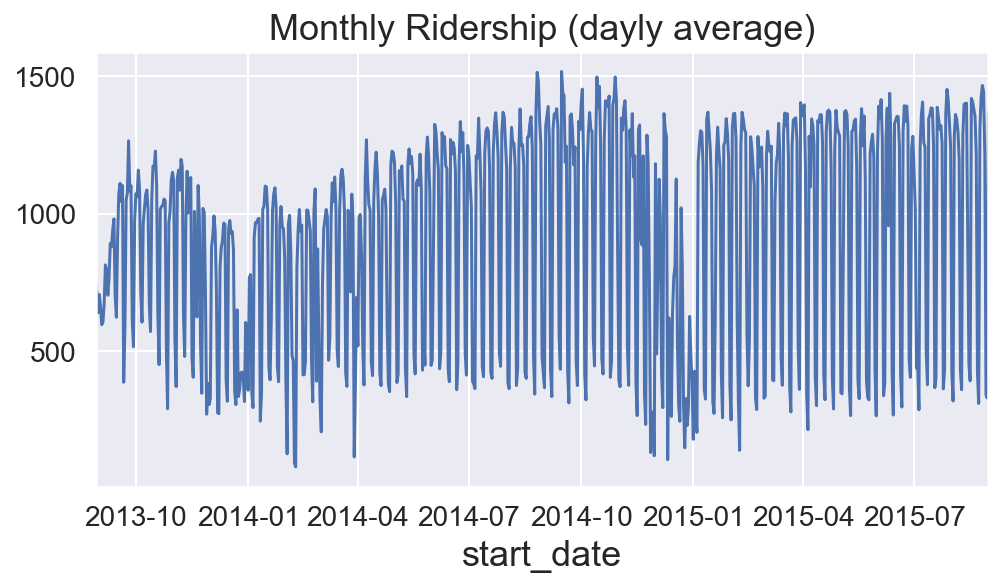

In [14]:
sf_per_day['count'].plot(
    figsize=(8, 4), title='Monthly Ridership (dayly average)', fontsize=14)
plt.show()

CLASSIFICATION

In [15]:
sf_per_day = sanfran.groupby([sanfran["start_date"].dt.date]).mean()
sf_per_day["count"] = sanfran.groupby([sanfran["start_date"].dt.date]).count()["mean_temperature_c"]
mean_count = sf_per_day['count'].mean()
list_bin = []
for val in sf_per_day['count']:
    if val > mean_count:
        list_bin.append(1)
    else:
        list_bin.append(0)
        
sf_per_day['count_class'] = list_bin
sf_per_day.dropna(inplace=True)
del sf_per_day['count']
X = sf_per_day.copy()
y = X.pop('count_class')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1)
pipe_class.fit(X_train, y_train)
# print(pipe.named_steps['model'].coef_)
print('Baseline:',sf_per_day.count_class.value_counts(normalize=True).max())
print('cross_val_score:', cross_val_score(pipe_class, X_train, y_train, cv=5).mean())
print('train_score:',pipe_class.score(X_train, y_train))
print('test_score:',pipe_class.score(X_test, y_test))

Baseline: 0.6024930747922438
cross_val_score: 0.930729178800233
train_score: 0.9544554455445544
test_score: 0.9493087557603687


# LA 

# Chicago 

# London
LINEAR

In [16]:
london_per_day = london.groupby([london["timestamp"].dt.date]).mean()
london_per_day.head()
X = london_per_day.copy()
y = X.pop('cnt')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
pipe.fit(X_train, y_train)
print(cross_val_score(pipe, X_train, y_train, cv=5).mean())
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.7981013700336702
0.8070210648840047
0.7200972039823934


In [17]:
pd.date_range(start = \
              london_per_day.index.min(), end = london_per_day.index.max() ).difference(london_per_day.index)

DatetimeIndex(['2016-09-02'], dtype='datetime64[ns]', freq=None)

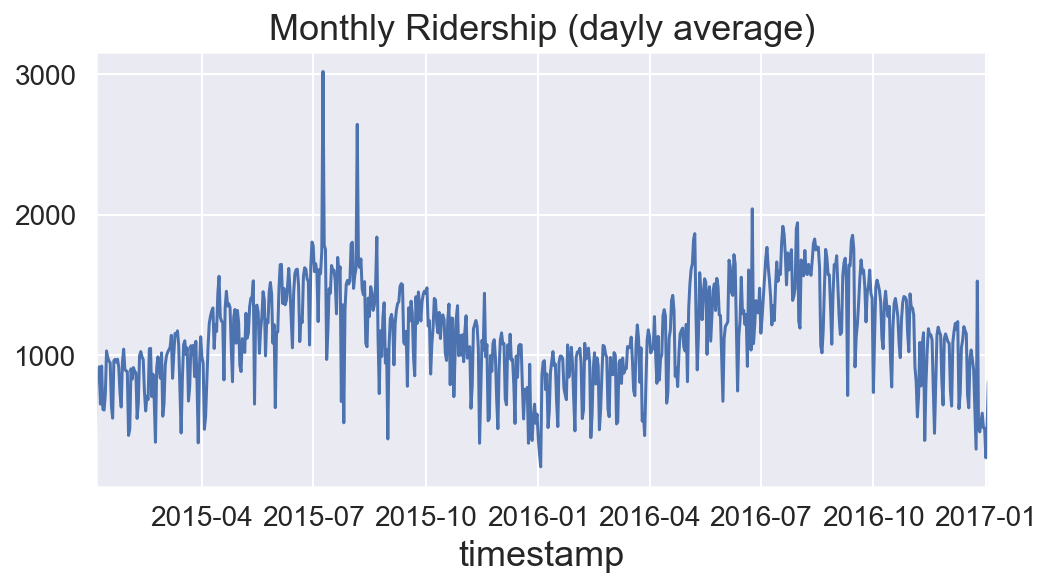

In [18]:
london_per_day['cnt'].plot(
    figsize=(8, 4), title='Monthly Ridership (dayly average)', fontsize=14)
plt.show()

CLASSIFICATION

In [19]:
london_per_day = london.groupby([london["timestamp"].dt.date]).mean()
del london_per_day['is_weekend']
del london_per_day['hum_binary']
del london_per_day['t2']
mean_count = london_per_day['cnt'].mean()
list_bin = []
for val in london_per_day['cnt']:
    if val > mean_count:
        list_bin.append(1)
    else:
        list_bin.append(0)
        
london_per_day['count_class'] = list_bin
del london_per_day['cnt']
X = london_per_day.copy()
y = X.pop('count_class')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1)
pipe_class.fit(X_train, y_train)
print('Baseline:',london_per_day.count_class.value_counts(normalize=True).max())
print(cross_val_score(pipe_class, X_train, y_train, cv=5).mean())
print(pipe_class.score(X_train, y_train))
print(pipe_class.score(X_test, y_test))

Baseline: 0.510958904109589
0.874814391776128
0.8747553816046967
0.867579908675799


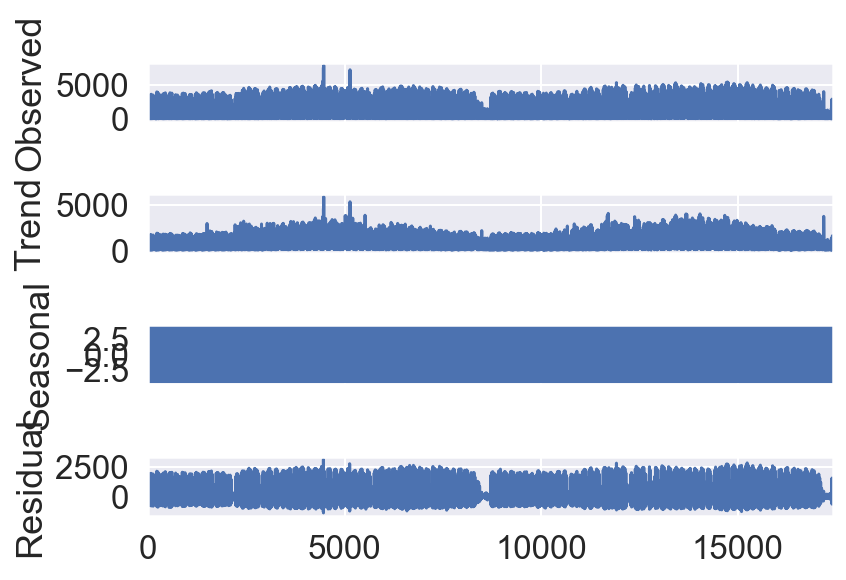

In [20]:
# LONDON TIMESERIES:
london.index.name = None
seasonal_decompose(london.cnt, freq=5).plot()
plt.show()

In [21]:
london.set_index('timestamp',inplace =True)

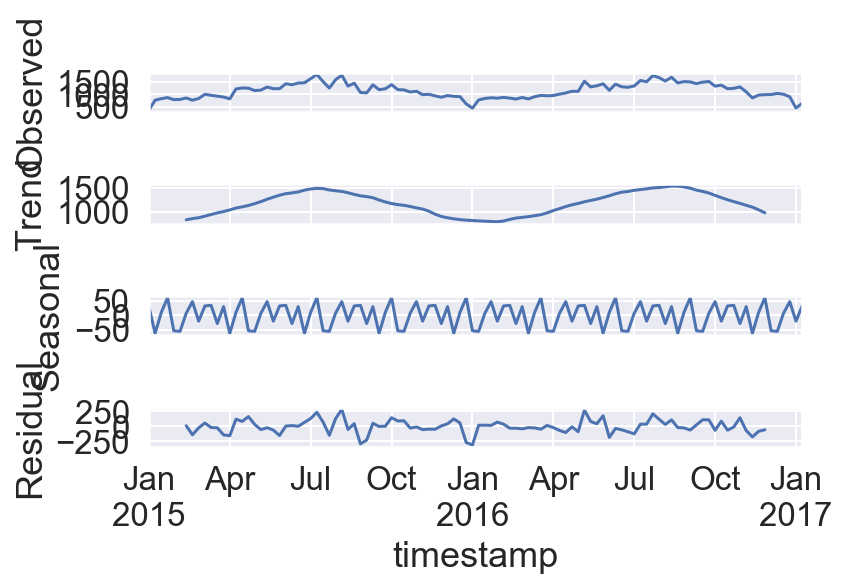

In [22]:
seasonal_decompose(london.cnt.resample('W').mean(), freq=12).plot()
plt.show()

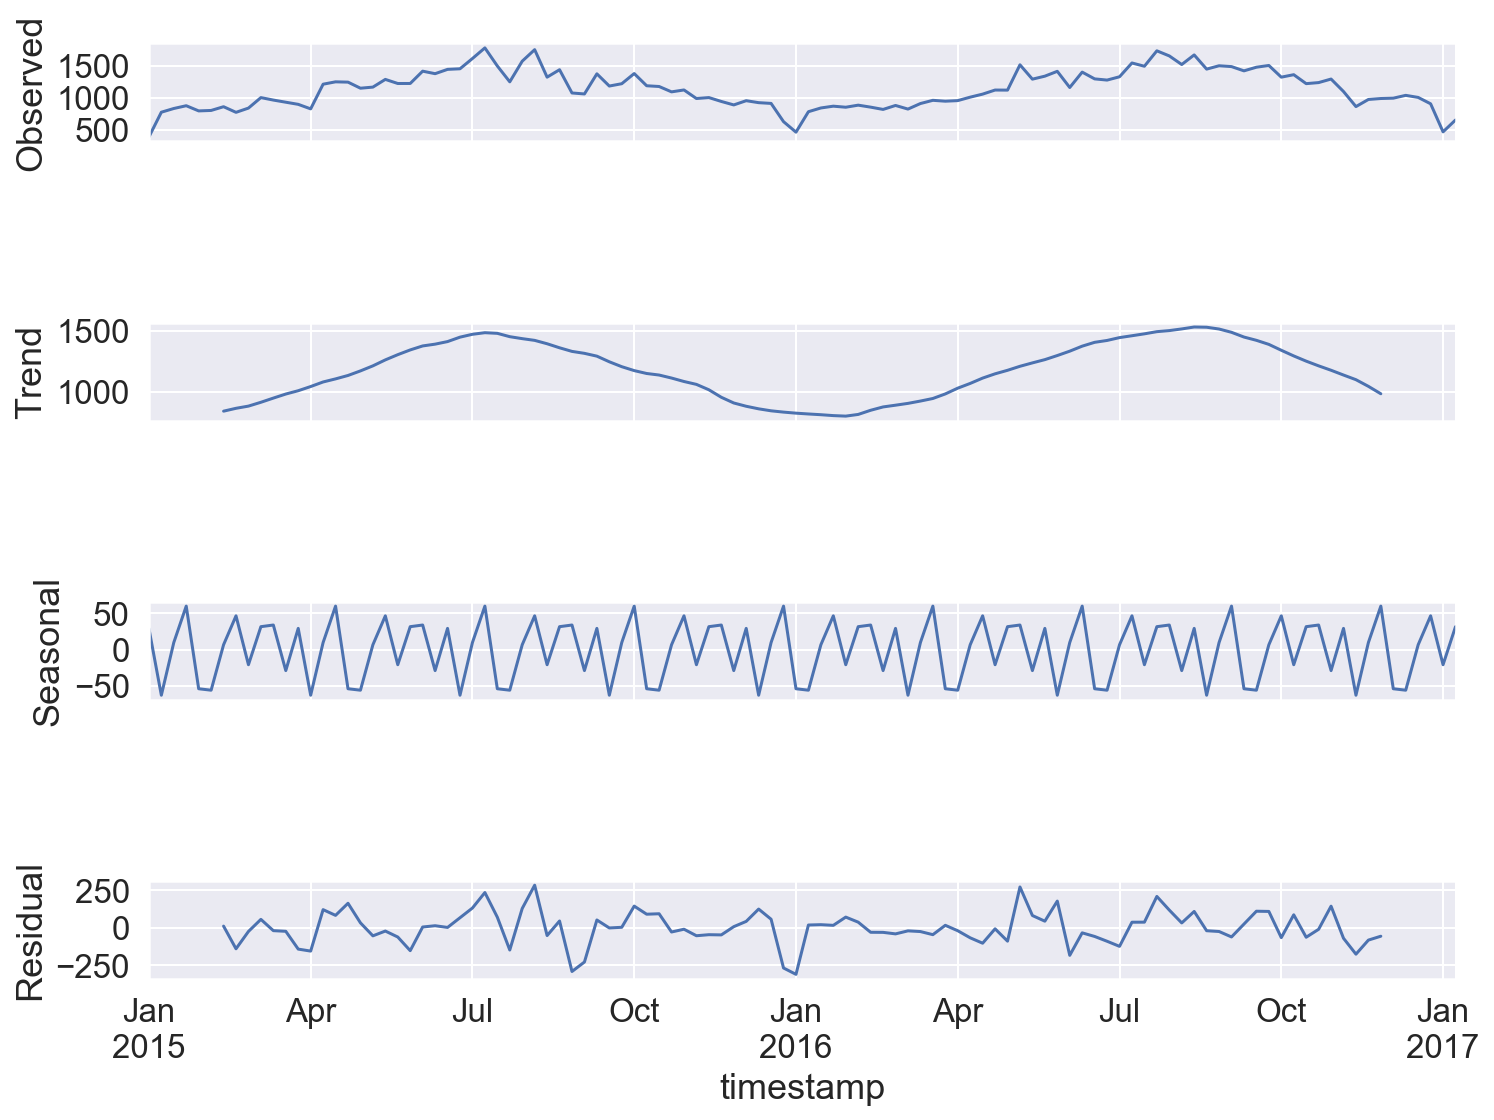

In [23]:
decomposition = seasonal_decompose(london.cnt.resample('W').mean(), freq=12)
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

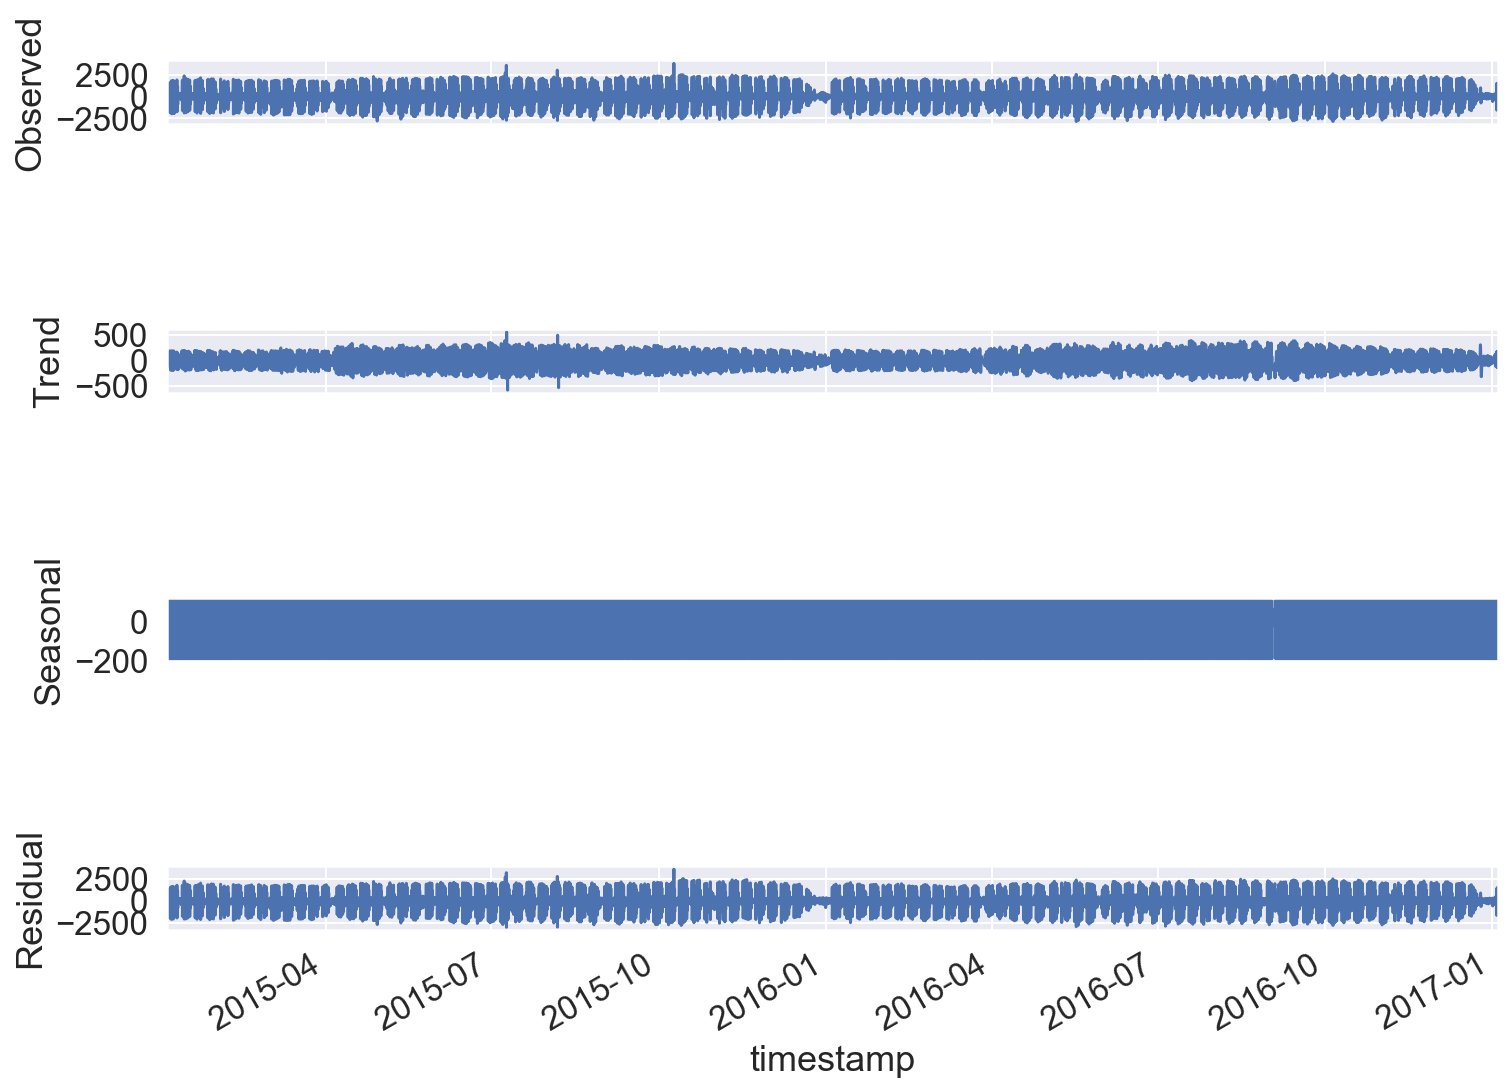

In [24]:
fig2 = seasonal_decompose(london.cnt.diff()[1:], freq=12).plot()
fig2.set_size_inches(12, 10)
plt.show()

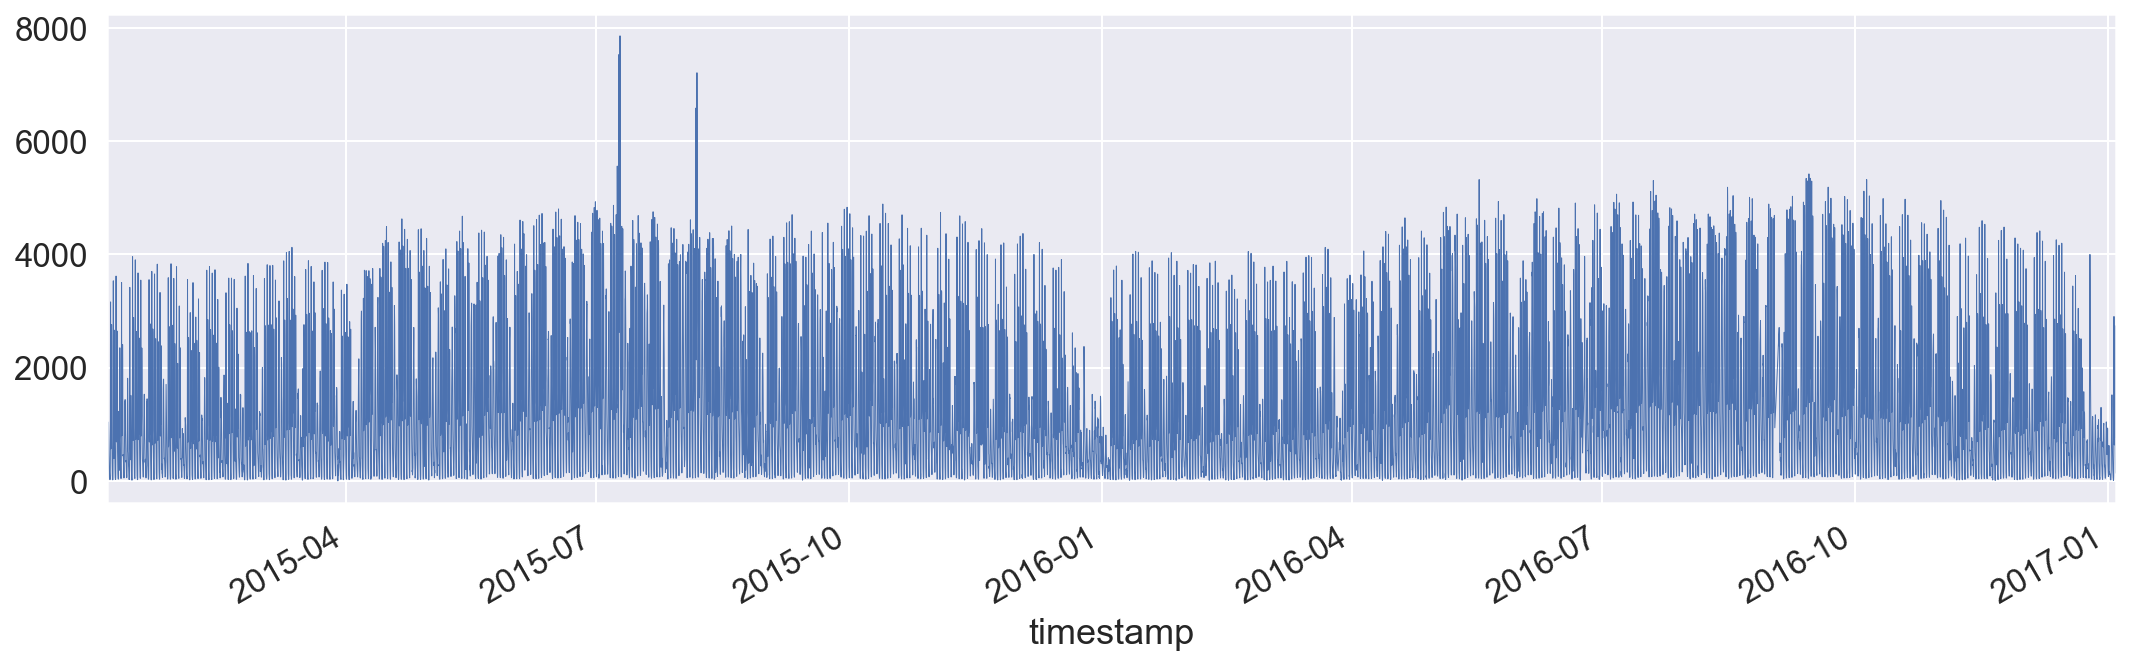

In [25]:
london['cnt'].plot(lw=.5, figsize=(18, 5))
plt.show()

# DC 
LINEAR

In [26]:
DC['is_working'] = DC.Day.map(lambda x: 0 if x in ['Saturday', 'Sunday'] else 1)

In [27]:
dc_per_day = DC.groupby([DC["datetime"].dt.date]).mean()
dc_per_day["count"] = (DC["count"].groupby([DC["datetime"].dt.date]).sum())
del dc_per_day['casual']
del dc_per_day['registered']

X = dc_per_day.copy()
y = X.pop('count')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)
pipe.fit(X_train, y_train)
print(cross_val_score(pipe, X_train, y_train, cv=5).mean())
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.48606652841598275
0.5313304299953201
0.35375821340499425


In [28]:
print((-cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()))

1734952.20061029


In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
mean_squared_error(y_train, pipe.predict(X_train))

1593608.7159053206

In [31]:
DC.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  hum_binary       Day  \
0        81        0.0       3          13     16           1  Saturday   
1        80        0.0       8          32     40           1  Saturday   
2        80        0.0       5          27     32           1  Saturday   
3        75        0.0       3          10     13           1  Saturday   
4        75        0.0       0           1      1           1  Saturday   

   is_working  
0           0  
1           0  
2           0  
3           0  
4           0

In [32]:
dc_per_day.index.min(),dc_per_day.index.max()

(datetime.date(2011, 1, 1), datetime.date(2012, 12, 19))

In [33]:
pd.date_range(start = dc_per_day.index.min(), end = dc_per_day.index.max() ).difference(dc_per_day.index)

DatetimeIndex(['2011-01-20', '2011-01-21', '2011-01-22', '2011-01-23',
               '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27',
               '2011-01-28', '2011-01-29',
               ...
               '2012-11-21', '2012-11-22', '2012-11-23', '2012-11-24',
               '2012-11-25', '2012-11-26', '2012-11-27', '2012-11-28',
               '2012-11-29', '2012-11-30'],
              dtype='datetime64[ns]', length=263, freq=None)

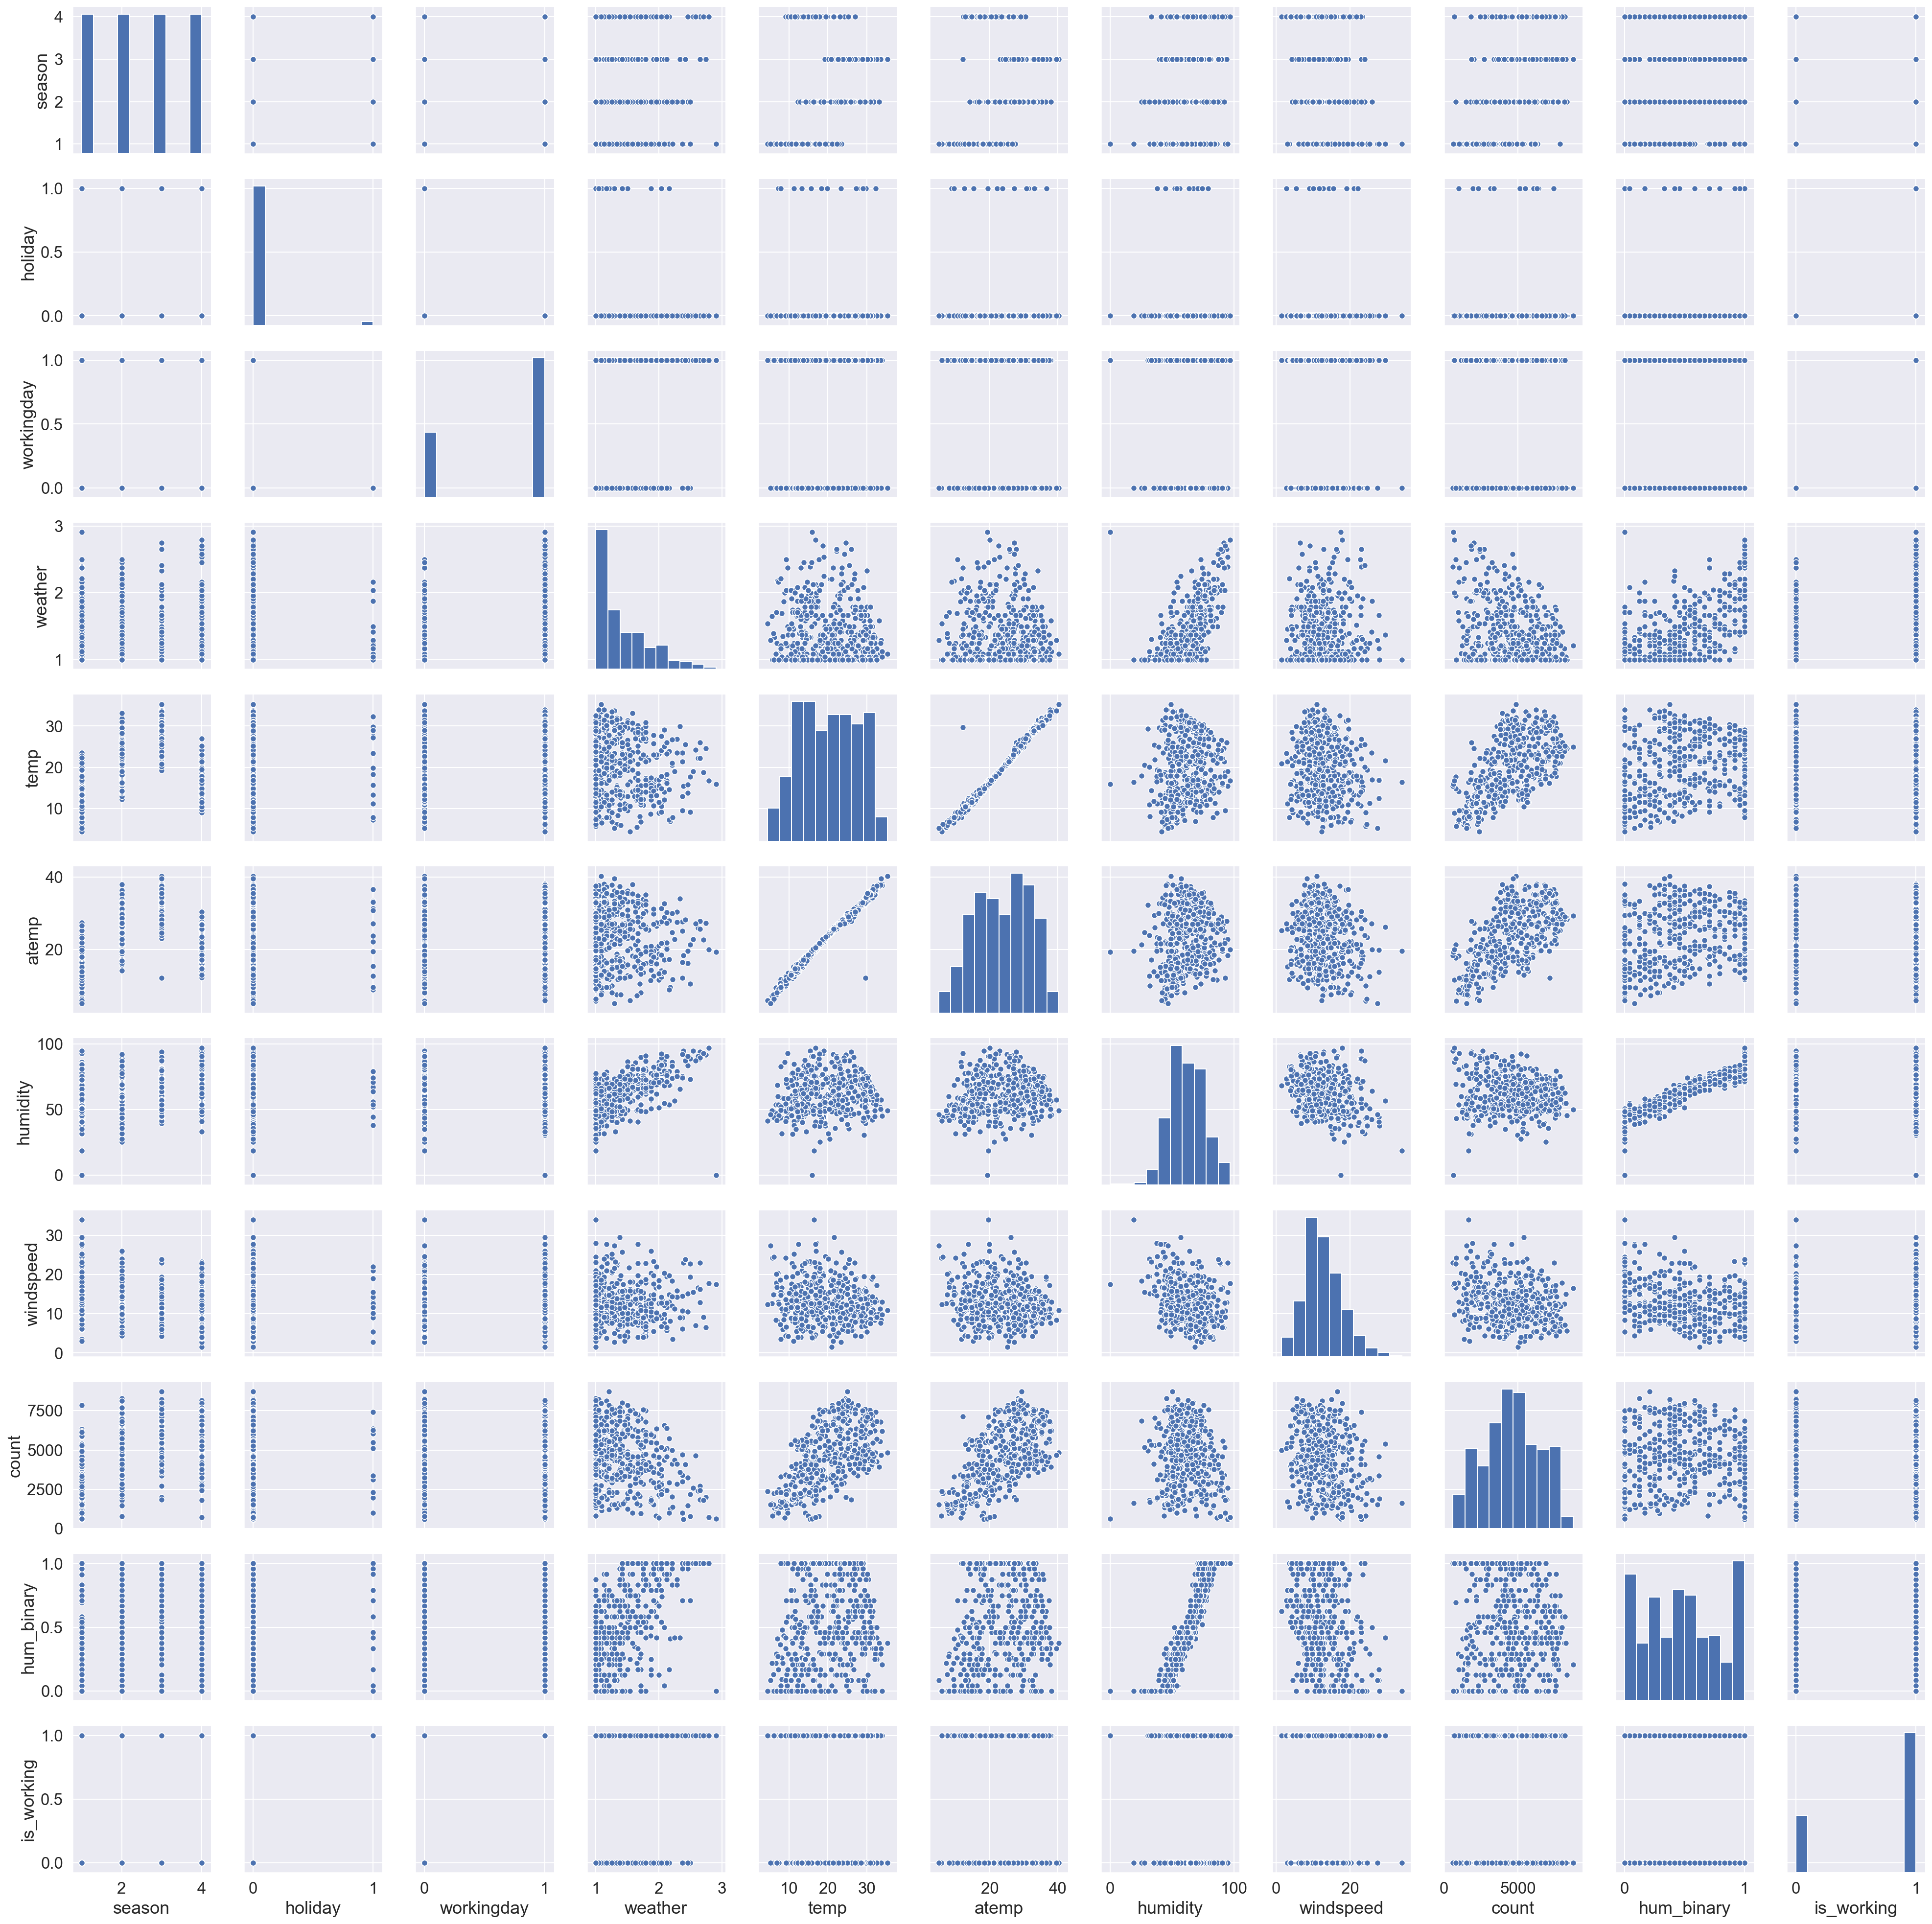

In [34]:
sns.pairplot(dc_per_day);

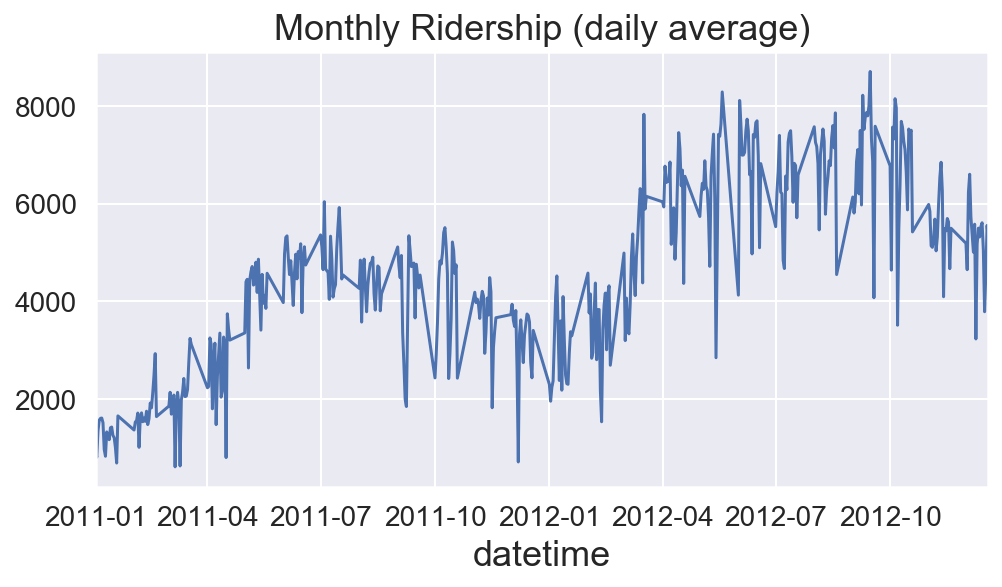

In [35]:
dc_per_day['count'].plot(
    figsize=(8, 4), title='Monthly Ridership (daily average)', fontsize=14)
plt.show()

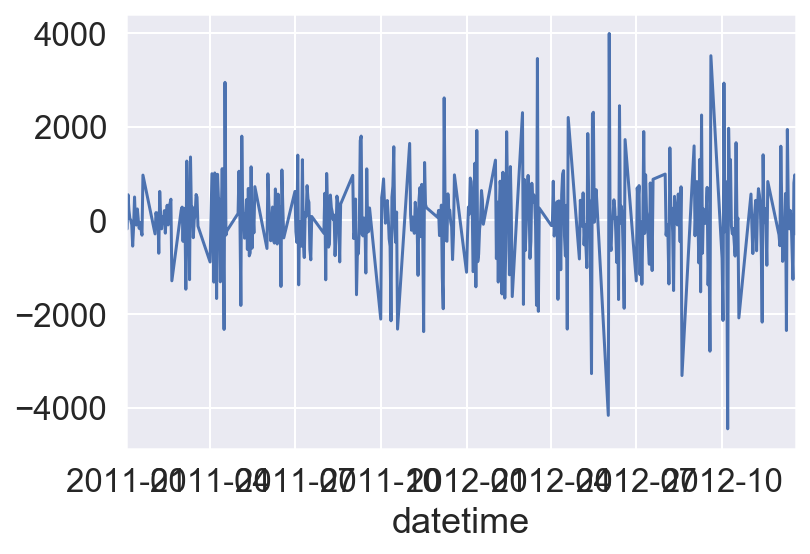

In [36]:
dc_per_day['count'].diff().plot();

In [37]:
dc_per_day['count'].head()

datetime
2011-01-01     985
2011-01-02     801
2011-01-03    1349
2011-01-04    1562
2011-01-05    1600
Name: count, dtype: int64

In [38]:
dc_per_day['count'].diff().head()

datetime
2011-01-01      NaN
2011-01-02   -184.0
2011-01-03    548.0
2011-01-04    213.0
2011-01-05     38.0
Name: count, dtype: float64

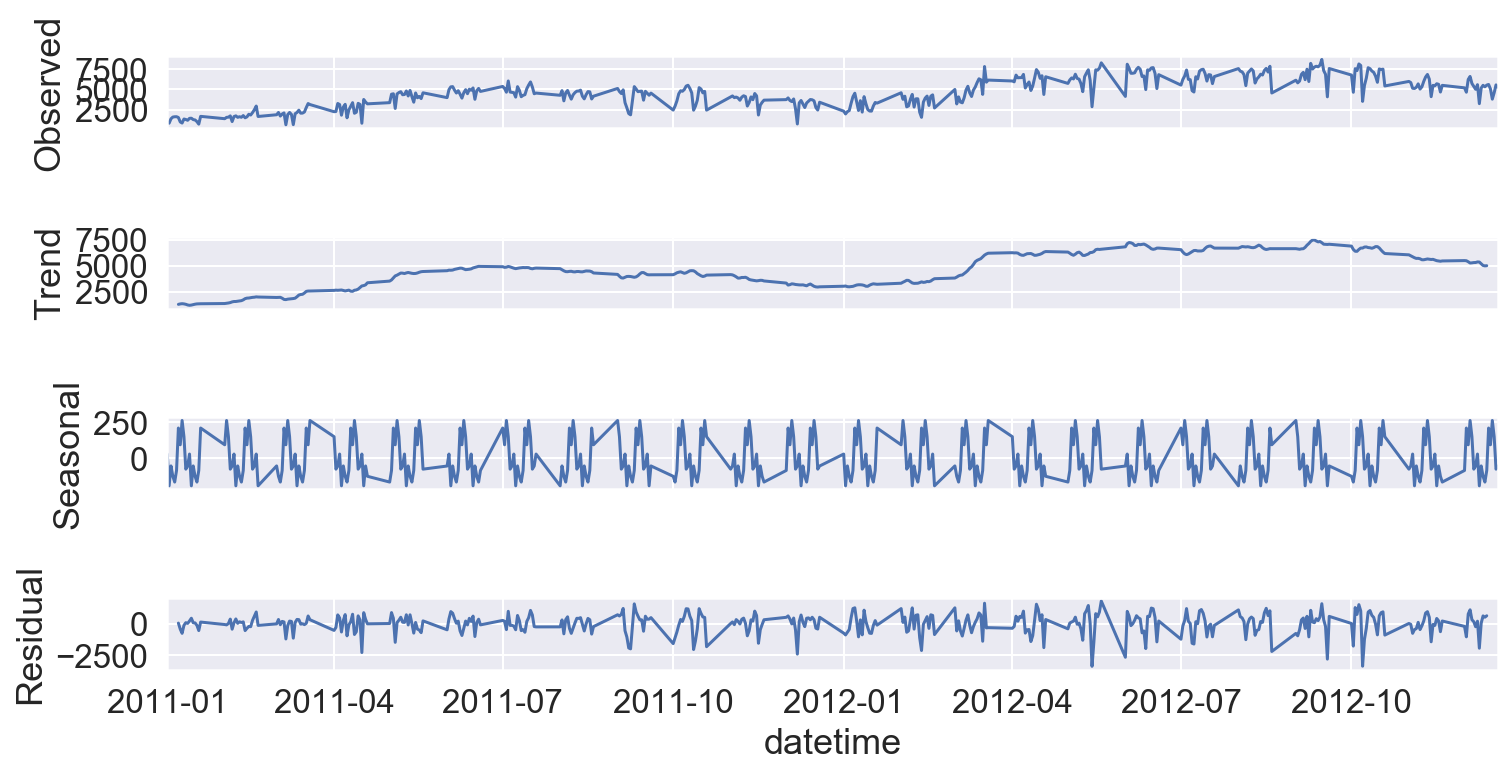

In [39]:
decomposition = seasonal_decompose(dc_per_day['count'], freq=12)
fig = decomposition.plot()
fig.set_size_inches(12, 6)
plt.show()

In [40]:
# dc_per_day['count'].diff().head()
# dc_per_day['count'].diff().diff().head()

In [41]:
dc_per_day['seasonal_difference'] = dc_per_day['count'] - dc_per_day['count'].shift(12)

In [42]:
dc_per_day['count'].mean()

4573.412280701755

In [43]:
dc_per_day.index

Index([2011-01-01, 2011-01-02, 2011-01-03, 2011-01-04, 2011-01-05, 2011-01-06,
       2011-01-07, 2011-01-08, 2011-01-09, 2011-01-10,
       ...
       2012-12-10, 2012-12-11, 2012-12-12, 2012-12-13, 2012-12-14, 2012-12-15,
       2012-12-16, 2012-12-17, 2012-12-18, 2012-12-19],
      dtype='object', name='datetime', length=456)

In [44]:
data = dc_per_day['count']
model = sm.tsa.statespace.SARIMAX(data,
                                  order=(2, 1, 0),
                                  seasonal_order=(1, 1, 1, 12))
results = model.fit(maxiter=10000)
results.summary()

/Users/vilvaki/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              count   No. Observations:                  456
Model:             SARIMAX(2, 1, 0)x(1, 1, 1, 12)   Log Likelihood               -3667.489
Date:                            Wed, 11 Dec 2019   AIC                           7344.977
Time:                                    19:40:56   BIC                           7365.445
Sample:                                         0   HQIC                          7353.050
                                            - 456                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4303      0.039    -11.096      0.000      -0.506      -0.354
ar.L2         -0.2353      0.044     -5.336      0.000      -0.322      -0.149
ar.S.L12      -0.0471      0.047     -1.008      0.314      -0.139       0.045
ma.S.L12      -0.9995      0.044    -22.812      0.000      -1.085      -0.914
sigma2      8.345e+05   5.28e-08   1.58e+13      0.000    8.34e+05    8.34e+05
===================================================================================
Ljung-Box (Q):                      132.96   Jarque-Bera (JB):               197.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.11   Skew:                            -0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.65e+27. Standard errors may be unstable.
"""

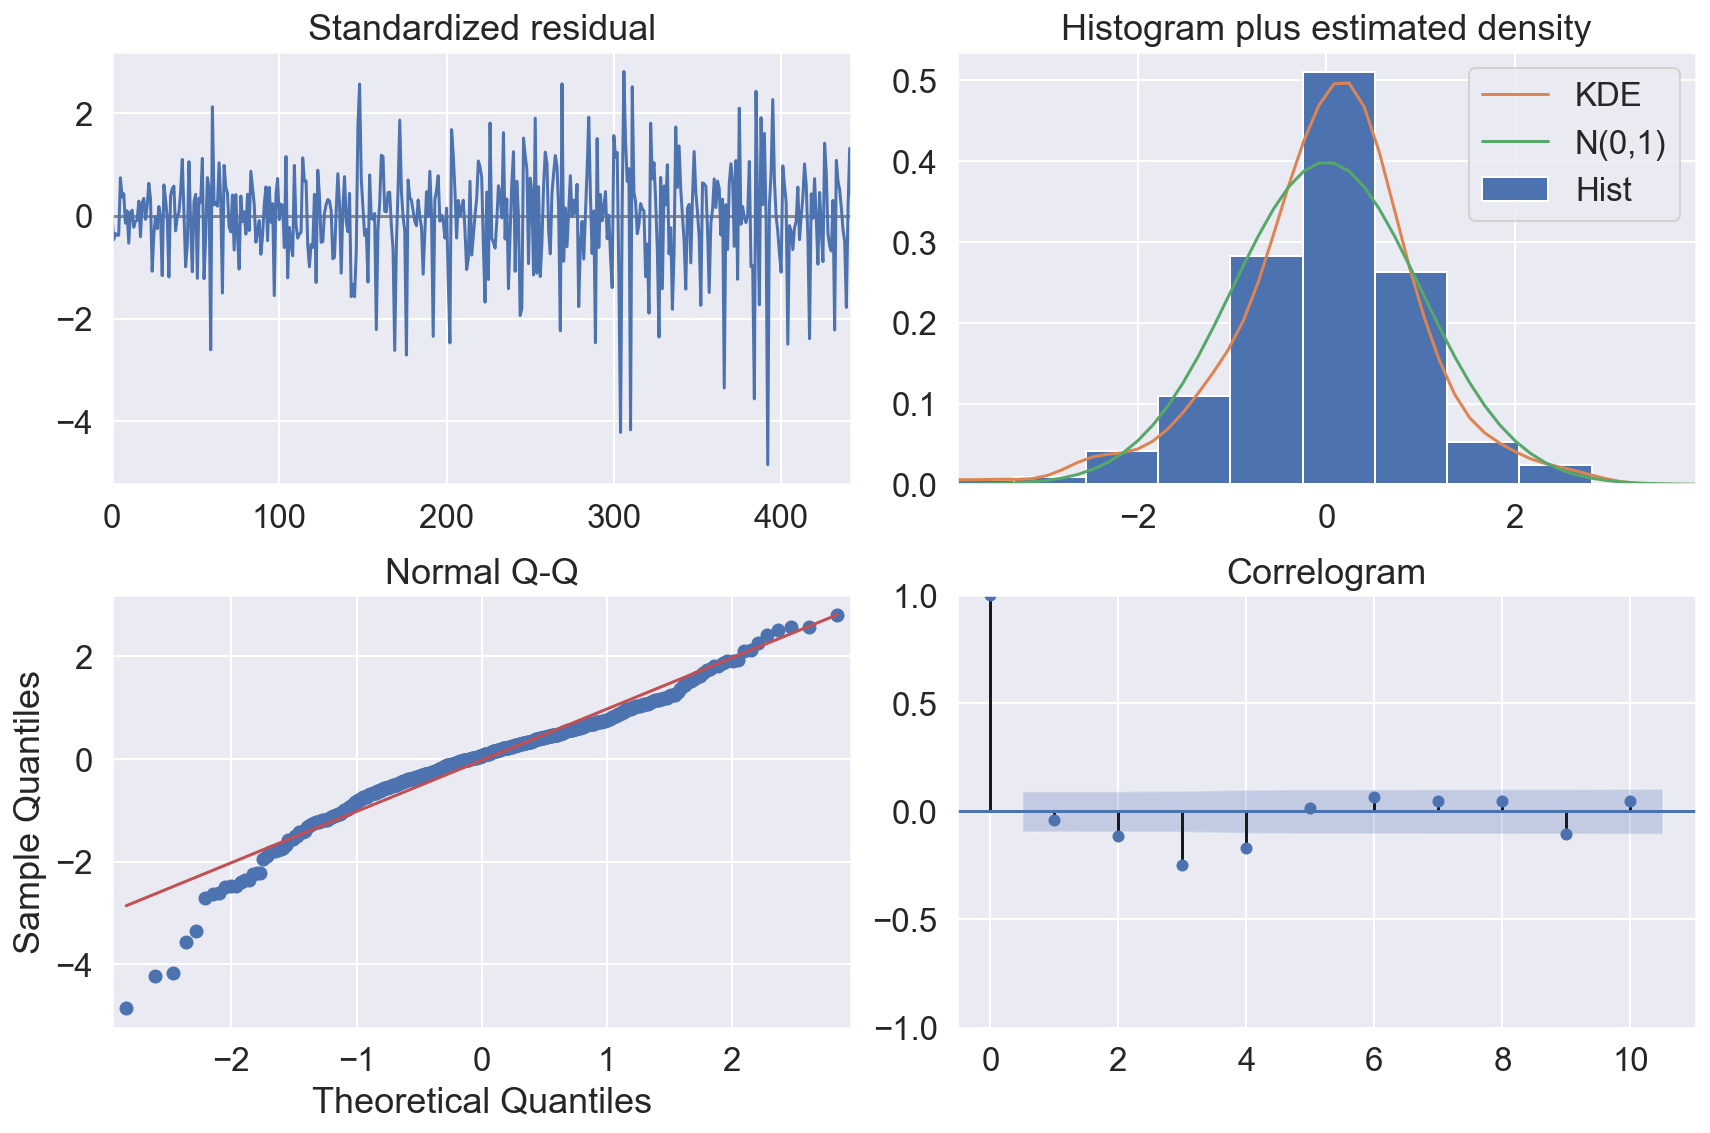

In [45]:
results.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

In [46]:
dc_per_day.head(2)

season  holiday  workingday   weather       temp      atemp  \
datetime                                                                  
2011-01-01     1.0      0.0         0.0  1.583333  14.110833  18.181250   
2011-01-02     1.0      0.0         0.0  1.956522  14.902609  17.686957   

             humidity  windspeed  count  hum_binary  is_working  \
datetime                                                          
2011-01-01  80.583333  10.749871    985    1.000000         0.0   
2011-01-02  69.608696  16.652122    801    0.695652         0.0   

            seasonal_difference  
datetime                         
2011-01-01                  NaN  
2011-01-02                  NaN

In [47]:
dc_per_day.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'hum_binary', 'is_working',
       'seasonal_difference'],
      dtype='object')

exogeneous columns

In [48]:
data_1 = [['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'is_working',
       'seasonal_difference']
data_1 = pd.get_dummies(dc_per_day, columns=['season', 'is_working'], drop_first=True)

SyntaxError: invalid syntax (<ipython-input-48-98cb577cf293>, line 4)

In [ ]:
exog_columns = [col for col in data_1.columns if 'Day' in col] + \
    ['Promo', 'Customers']

In [ ]:
model = sm.tsa.statespace.SARIMAX(data_1['count'],
                                  exog=data_1[exog_columns],
                                  order=(3, 1, 1),
                                  seasonal_order=(1, 1, 0, period))
results = model.fit(maxiter=1000)
results.summary()

CLASSIFICATION

In [ ]:
dc_per_day = DC.groupby([DC["datetime"].dt.date]).mean()
dc_per_day["count"] = (DC["count"].groupby([DC["datetime"].dt.date]).sum())
mean_count = dc_per_day['count'].mean()
list_bin = []
for val in dc_per_day['count']:
    if val > mean_count:
        list_bin.append(1)
    else:
        list_bin.append(0)
                
dc_per_day['count_class'] = list_bin
del dc_per_day['count']
X = dc_per_day.copy()
y = X.pop('count_class')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1)
pipe_class.fit(X_train, y_train)
print('Baseline:',dc_per_day.count_class.value_counts(normalize=True).max())
print(cross_val_score(pipe_class, X_train, y_train, cv=5).mean())
print(pipe_class.score(X_train, y_train))
print(pipe_class.score(X_test, y_test))

In [ ]:
dc = dc_per_day.copy()
del dc['hum_binary']
# dc['Day'] = dc.datetime.dt.weekday_name

In [ ]:
dc.head()

In [ ]:
time_index = pd.date_range(start = dc.index.min(), end = dc.index.max())
dc = dc.reindex(time_index)

In [ ]:
dc.reset_index(inplace = True)

In [ ]:
dc['Day'] = dc['index'].dt.weekday_name

In [ ]:
dc['is_working'] = dc.Day.map(lambda x: 0 if x in ['Saturday', 'Sunday'] else 1)

In [ ]:
import holidays

In [ ]:
dc_holidays_11 = holidays.UnitedStates(state='DC', years=2011)
dc_holidays_12 = holidays.UnitedStates(state='DC', years=2012)
dc_holidays = dc_holidays_11 +dc_holidays_12

In [ ]:
# dc_holidays_12

In [ ]:
dc['is_holiday'] = dc['index'].map(lambda x: 1 if x.date() in dc_holidays.keys() else 0)

In [ ]:
dc.drop(['season','holiday','workingday'],axis=1,inplace=True)

In [ ]:
# dc.resample('M').mean()
dc.head(50)

In [ ]:
dc.set_index('index', inplace=True)

In [ ]:
dc.ffill()[['weather','temp','atemp','humidity','windspeed']].rolling(window=5).mean().head(30)

In [ ]:
dc.isnull().sum()